In [93]:
import pandas as pd
import numpy as np
import math

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF


from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri


import matplotlib.pyplot as plt

import SMOTE

In [98]:
df = pd.read_csv('/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/commit_guru/ant.csv')
df = df.drop(labels = ['commit_hash', 'author_name', 'author_date_unix_timestamp',
       'author_email', 'author_date', 'commit_message','classification', 'linked', 'contains_bug', 'fixes',
                      'fileschanged','glm_probability', 'rf_probability',
       'repository_id', 'issue_id', 'issue_date', 'issue_type'],axis=1)
df = df.dropna()
df = df[['ns', 'nd', 'nf', 'entropy', 'la', 'ld', 'lt', 'ndev', 'age',
       'nuc', 'exp', 'rexp', 'sexp','fix']]

In [99]:
y = df.fix
y=y.astype('bool')
X = df.drop(labels=['fix'],axis=1)
train_X,test_X,train_y,test_y = train_test_split(X, y, test_size=0.33, random_state=13)

In [100]:
print(train_X.shape)
df_new = train_X
df_new['fix'] = train_y
smt = SMOTE.smote(train_X)
df = smt.run()
df.columns = ['ns', 'nd', 'nf', 'entropy', 'la', 'ld', 'lt', 'ndev', 'age',
       'nuc', 'exp', 'rexp', 'sexp','fix']
train_y = df.fix
train_y=train_y.astype('bool')
train_X = df.drop(labels=['fix'],axis=1)
print(train_X.shape)

(9560, 13)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(15258, 13)


In [107]:
clf = LogisticRegression(penalty='l1',class_weight = 'balanced')
#clf = RandomForestClassifier(criterion = 'gini',n_estimators=100)
#clf = SVC()
#clf = linear_model.SGDClassifier(loss = 'modified_huber',max_iter=1000, tol=1e-3,penalty='l1')
#clf = KNeighborsClassifier(n_neighbors=5,algorithm='kd_tree')
#kernel = 1.0 * RBF(1.0)
#clf = GaussianProcessClassifier(kernel=kernel,random_state=0)
clf.fit(train_X,train_y)
predicted = clf.predict(test_X)
fpr, tpr, thresholds = metrics.roc_curve(test_y, predicted, pos_label=1)
print(metrics.auc(fpr, tpr))
print(classification_report(test_y, predicted))
print(clf.coef_)

0.5161852455211665
              precision    recall  f1-score   support

       False       0.80      0.68      0.74      3751
        True       0.22      0.35      0.27       958

    accuracy                           0.61      4709
   macro avg       0.51      0.52      0.50      4709
weighted avg       0.69      0.61      0.64      4709

[[ 1.98796741e-01  3.52930795e-02 -2.80566961e-03 -6.76670137e-02
  -3.49689814e-06  1.24419172e-05  1.49586632e-04  1.30074742e-02
   7.69981189e-04 -3.43648674e-02 -6.52441906e-05  8.56499800e-04
   1.96736908e-04]]


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [57]:
# For using with r package
train_df = train_X
test_df = test_X
train_df['fix'] = train_y.values
test_df['fix'] = test_y.values

with localconverter(ro.default_converter + pandas2ri.converter):
    train_df_r = ro.conversion.py2rpy(train_df)
    test_df_r = ro.conversion.py2rpy(test_df)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [86]:
stats = importr('stats', robject_translations={'format_perc': '_format_perc'})
base = importr('base')
sig_threshold = 0.05
def _isMetricSignificant(formula_metrics, metric,data):
    """
    Checks if adding a metric to the already significant metrics in formula_metrics in a GLM model is significant. If significant,
    and doesn't cause any previous metric in formula_metrics to become non significant, we return true. Otherwise, false.
    Note: The p-value is always given in the 4th column of the summary matrix!
    """
    sig_column = 4

    # Case 1: no existing metrics in the formula
    if len(formula_metrics) == 0:
        formula = "fix~" + metric
        fit = stats.glm(formula, data=data, family="binomial")
        summary = base.summary(fit)
      # Note - first row is the intercept information so we start at second row!

        try:
            metric_sig = summary.rx2('coefficients').rx(2,sig_column)[0] # Second row, 4th column of the summary matrix.
            if metric_sig <= sig_threshold:
                return True
            else:
                return False

        except:
            # If we have two metrics that are perfectly collinear it will not build the model with the metrics
            # and we will get an exception when trying to find the significance of *all values*. Indeed, do not add
            # this value to the model!
            return False

    # Case 2: existing metrics in the formula    
    else:
        num_metrics = len(formula_metrics)+2 # plus one for the new metric we are adding and one for intercept
        formula = "fix~" + "+".join(formula_metrics) + "+" + metric
        fit = stats.glm(formula, data=data, family="binomial")
        summary = base.summary(fit)

      # If any metric is now not significant, than we should not have added this metric to the formula
      # There are (intercept) + num_metrics rows in the matrix to check - starts at second row skipping intercept
        try: 
            for row in range(2,num_metrics+1):
                metric_sig = summary.rx2('coefficients').rx(row,sig_column)[0]
                if metric_sig > sig_threshold:
                    return False
            return True # old metrics added to model ARE significant still as well as the new one being tested

        except:
            # If we have two metrics that are perfectly collinear it will not build the model with the metrics
            # and we will get an exception when trying to find the significance of *all values*. Indeed, do not add
            # this value to the model!
            return False

        
def _getInterceptValue(coefs, data):
    """
    Return the Intercept value of a GLM model and the p-value
    Assumes that model can be built!
    """
    formula = "fix~" + "+".join(coefs)
    print(formula)
    fit = stats.glm(formula, data=data, family="binomial")
    summary = base.summary(fit)
    return summary.rx2('coefficients').rx(1)[0], summary.rx2('coefficients').rx(1,4)[0]

def _getCoefficients(formula_coefs,data):
    """
    Builds a GLM model with a formula based on the passed in coefficients and retuns a dictionary containing each
    coefficient with its value.
    """
    coef_dict = {} # a dict containing glm coefficients {name -> value}
    formula = "fix~" + "+".join(formula_coefs)
    fit = stats.glm(formula, data=data, family="binomial")

    for coef in formula_coefs:
        coef_dict[coef] = fit.rx2('coefficients').rx2(coef)[0]

    return coef_dict

In [87]:
metrics_list = ["la","ld","lt","ns","nd","nf","ndev","age","nuc","exp","rexp","sexp","entropy"]
formula_metrics = []
for metric in metrics_list:
    if _isMetricSignificant(formula_metrics, metric,train_df_r):
        formula_metrics.append(metric)

In [88]:
intercept_value, intercept_pvalue = _getInterceptValue(formula_metrics,train_df_r)
coefs = _getCoefficients(formula_metrics,train_df_r)

fix~lt+ns+nf+ndev+age+exp+rexp+sexp


In [89]:
predicted = []
risks = []
predicted_t = []
predicted_f = []
for commit in test_X.itertuples():
    coefs_sum = 0
    for coef_name in coefs:
        coefs_sum += (coefs[coef_name] * getattr(commit, coef_name))
    try:
        riskyness = 1/(1+ math.exp(-intercept_value-coefs_sum))
    except:
        riskyness = -1
    if riskyness >= 0.5:
        result = True
    else:
        result = False
    predicted.append(result)
    risks.append(riskyness)
y_train = test_y.values
for i in range(len(y_train)):
    if y_train[i]:
        predicted_t.append(risks[i])
    else:
        predicted_f.append(risks[i])

In [90]:
print(classification_report(test_y, predicted))

              precision    recall  f1-score   support

       False       0.80      0.68      0.74      3751
        True       0.22      0.35      0.27       958

    accuracy                           0.61      4709
   macro avg       0.51      0.52      0.50      4709
weighted avg       0.69      0.61      0.64      4709



(array([1.000e+00, 0.000e+00, 4.000e+00, 8.900e+01, 1.806e+03, 1.248e+03,
        4.110e+02, 1.620e+02, 2.400e+01, 6.000e+00]),
 array([0.0439992 , 0.12906852, 0.21413784, 0.29920716, 0.38427648,
        0.4693458 , 0.55441512, 0.63948444, 0.72455377, 0.80962309,
        0.89469241]),
 <a list of 10 Patch objects>)

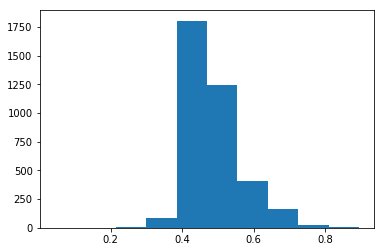

In [91]:
plt.hist(predicted_f)

(array([ 25., 357., 275., 137.,  81.,  51.,  25.,   4.,   1.,   2.]),
 array([0.3364512 , 0.39612191, 0.45579261, 0.51546332, 0.57513402,
        0.63480472, 0.69447543, 0.75414613, 0.81381684, 0.87348754,
        0.93315825]),
 <a list of 10 Patch objects>)

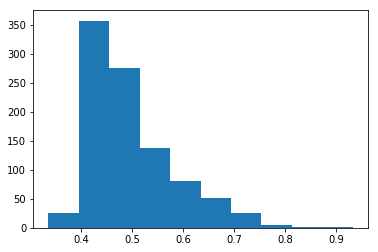

In [92]:
plt.hist(predicted_t)